In [7]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations

# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data

from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline
# Downloading NLTK resources
# nltk.download('stopwords')

In [8]:
df = pd.read_feather("../Data/Data145.feather")

In [9]:
X = df[['text', 'base_url']]
Y = df['sentiment']

In [10]:
stop_words_appened=stopwords.words('english').append(['rt', 'ep'])

In [11]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# TF-IDF Approach

In [12]:
# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_text = tfidf_vectorizer_text.fit_transform(X_train['text'])
X_test_tfidf_text = tfidf_vectorizer_text.transform(X_test['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_url = tfidf_vectorizer_url.fit_transform(X_train['base_url'])
X_test_tfidf_url = tfidf_vectorizer_url.transform(X_test['base_url'])

# Concatenating the TF-IDF matrices horizontally
X_train_tfidf_combined = hstack([X_train_tfidf_text, X_train_tfidf_url])
X_test_tfidf_combined = hstack([X_test_tfidf_text, X_test_tfidf_url])

# Creating and training the logistic regression model
Reg_tf = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced')
Reg_tf.fit(X_train_tfidf_combined, y_train)

# Predicting on the test set
y_pred = Reg_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8891614629794826
              precision    recall  f1-score   support

          -1       0.70      0.74      0.72       491
           0       0.92      0.93      0.93      2587
           1       0.90      0.86      0.88      1406

    accuracy                           0.89      4484
   macro avg       0.84      0.84      0.84      4484
weighted avg       0.89      0.89      0.89      4484



In [13]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 363,   80,   48],
       [  91, 2412,   84],
       [  66,  128, 1212]])

In [14]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

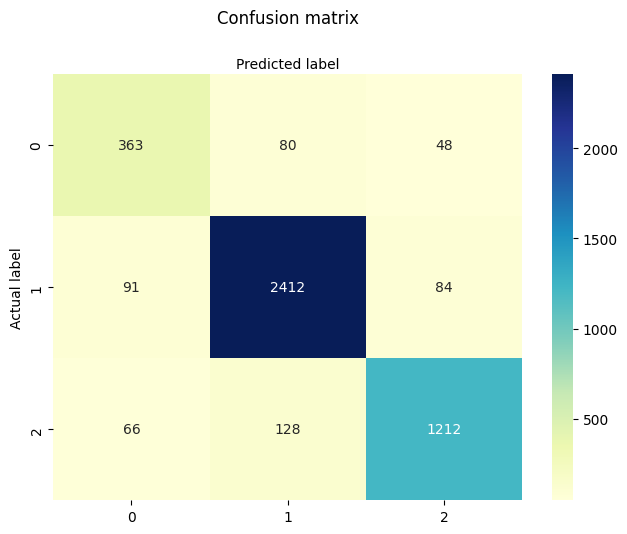

In [15]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

In [16]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4484, 3)

In [17]:
# changing labels to binary data
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [18]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = Reg_tf.predict_proba(X_test_tfidf_combined)
class_id

1

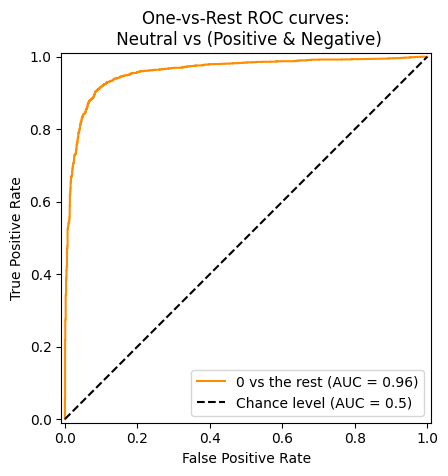

In [19]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

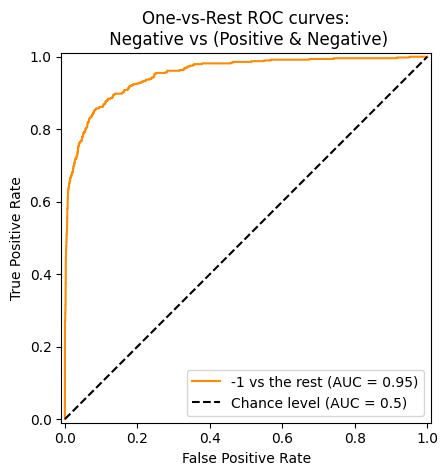

In [20]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Negative)",
)

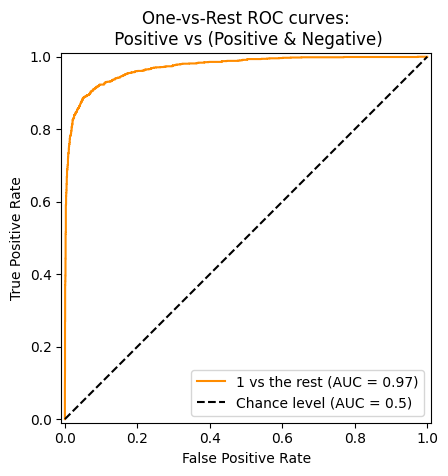

In [21]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Positive & Negative)",
)

## Roc Micro Averaged for TFIDF
##### Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

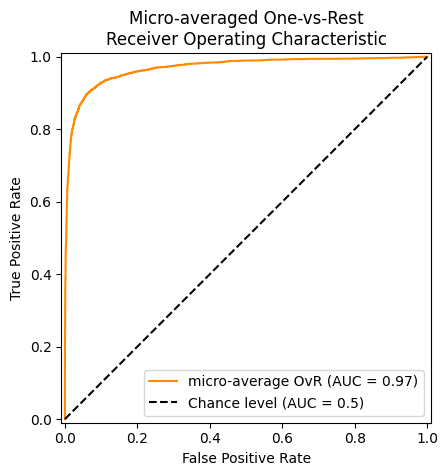

In [22]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [23]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9690507521639035


# Bag-Of-Words Approach

In [24]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_bow_text = bow_vectorizer_text.fit_transform(X_train['text'])
X_test_bow_text = bow_vectorizer_text.transform(X_test['text'])

# Creating BoW vectorizer for base_url
bow_vectorizer_url = CountVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_bow_url = bow_vectorizer_url.fit_transform(X_train['base_url'])
X_test_bow_url = bow_vectorizer_url.transform(X_test['base_url'])

# Concatenating the BoW matrices horizontally
X_train_bow_combined = hstack([X_train_bow_text, X_train_bow_url])
X_test_bow_combined = hstack([X_test_bow_text, X_test_bow_url])

In [25]:
# Creating and training the logistic regression model
Reg_bow = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced')
Reg_bow.fit(X_train_bow_combined, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr',
                   solver='liblinear')

In [26]:
# Predicting on the test set
y_pred = Reg_bow.predict(X_test_bow_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Printing the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8994201605709188
              precision    recall  f1-score   support

          -1       0.70      0.75      0.72       491
           0       0.93      0.94      0.93      2587
           1       0.92      0.88      0.90      1406

    accuracy                           0.90      4484
   macro avg       0.85      0.86      0.85      4484
weighted avg       0.90      0.90      0.90      4484



In [27]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

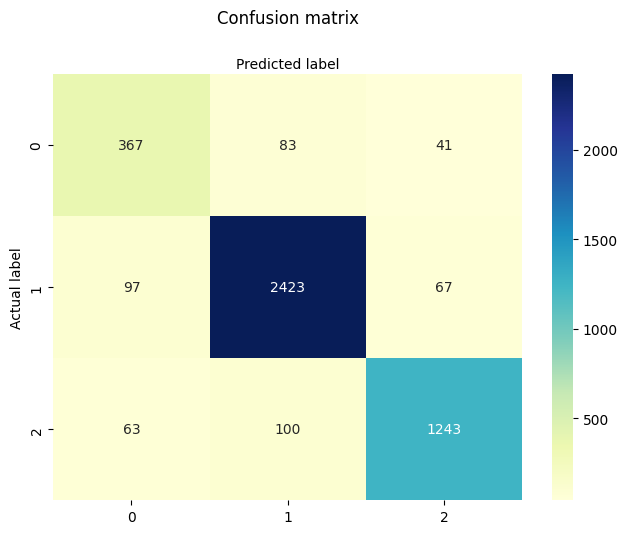

In [28]:
cm_bow = confusion_matrix(y_test, y_pred)

# plotting confusion matrix
plot_conf_mat(cm_bow)

In [29]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4484, 3)

In [30]:
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [31]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = Reg_tf.predict_proba(X_test_bow_combined)
class_id

1

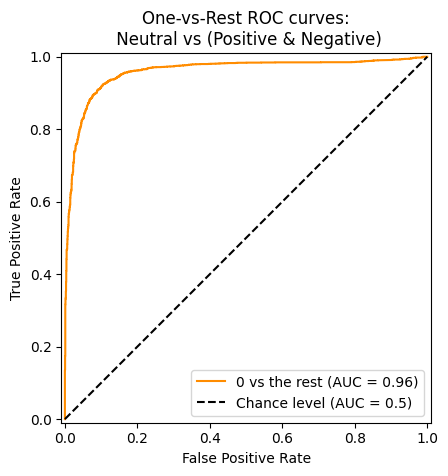

In [32]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

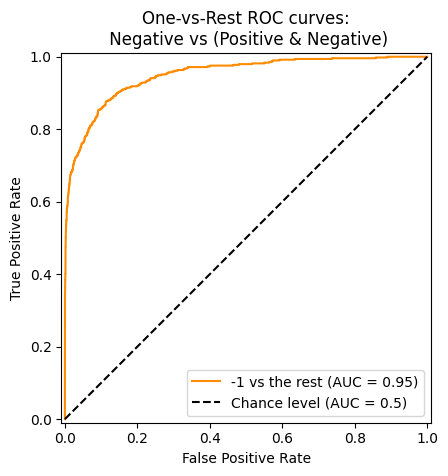

In [33]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Negative)",
)

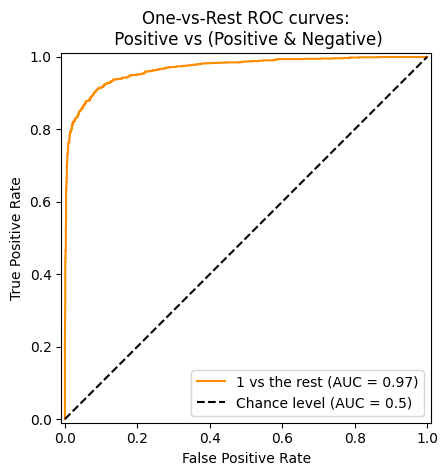

In [34]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Positive & Negative)",
)

## Roc Micro Averaged for BOW

##### Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

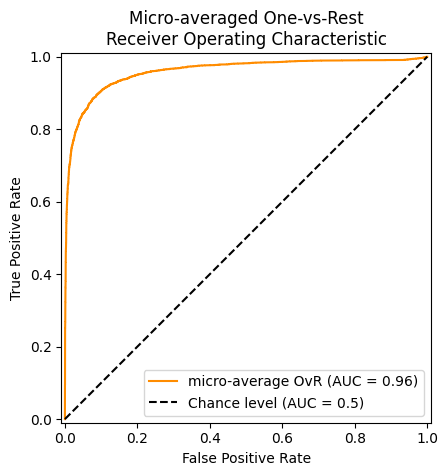

In [35]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [36]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9593946779549608


# K-Fold Cross Validation

In [37]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_url = tfidf_vectorizer_url.fit_transform(X['base_url'])

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_url])

In [38]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X['text'])

bow_vectorizer_url = CountVectorizer(max_features=1000)
X_bow_url = bow_vectorizer_url.fit_transform(X['base_url'])

X_bow_combined = hstack([X_bow_text, X_bow_url])

In [39]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    Regressor = LogisticRegression(random_state=50,max_iter=50, solver='newton-cg')
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # evaluate model
    scores = cross_val_score(Regressor, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>1 mean=0.9015 se=0.001
>2 mean=0.9013 se=0.001
>3 mean=0.9012 se=0.001
>4 mean=0.9012 se=0.001
>5 mean=0.9014 se=0.001
>6 mean=0.9014 se=0.001
>7 mean=0.9013 se=0.001
>8 mean=0.9013 se=0.001
>9 mean=0.9012 se=0.001


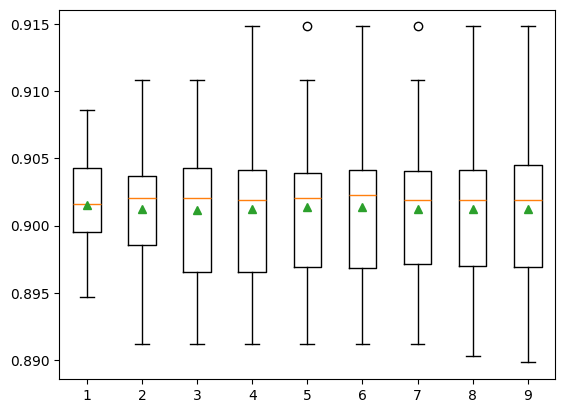

In [40]:
repeats = range(1,10)
results = list()
from scipy.stats import sem
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_tfidf_combined, Y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

>1 mean=0.9074 se=0.001
>2 mean=0.9071 se=0.001
>3 mean=0.9072 se=0.001
>4 mean=0.9074 se=0.001
>5 mean=0.9075 se=0.001
>6 mean=0.9073 se=0.001
>7 mean=0.9074 se=0.001
>8 mean=0.9074 se=0.001
>9 mean=0.9073 se=0.001


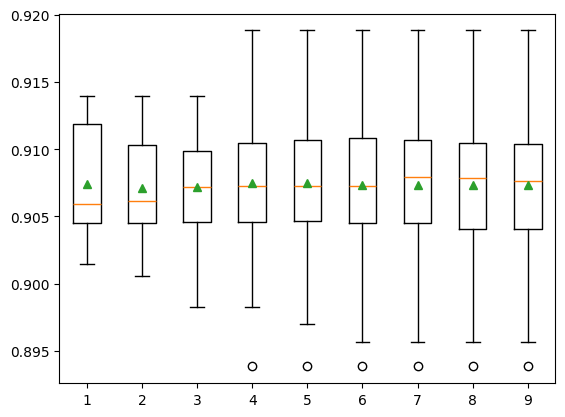

In [41]:
repeats = range(1,10)
results = list()
from scipy.stats import sem
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_bow_combined, Y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()